# **Administración del desarrollo de software**

## Maestría en Inteligencia Artificial Aplicada
#### Tecnológico de Monterrey
#### Prof. Gilberto Carlo Grajales Arana
#### Profa. Verónica Sandra Guzmán de Valle


### **Proyecto: Etapa 3. Entrega de sprint 2 y cierre del proyecto**

* **Nombres y matrículas:**

*   Mauricio Salvador Montes Macal A01625367
*   Michelle Andrea Arceo Solano A01625268
*   Abraham Avila García A01795305
*   Salvador Mendoza Pérez A01794998


* **Número de Equipo:** 23

Se desarrollará un prototipo funcional que, a partir de datos históricos de reservas, prediga la probabilidad de cancelación usando modelos de clasificación en Google Colab. Esto permitirá a los hoteles anticiparse a cancelaciones y optimizar su gestión de ingresos. Además, se analizarán las temporadas altas y bajas, así como la duración óptima de las estancias, para ajustar las tarifas diarias de manera estratégica y maximizar la rentabilidad.

# Librerías y conexiones

In [108]:
# Instalar Prophet
!pip install prophet --quiet

In [159]:
# Importación de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from prophet import Prophet
from IPython.display import display, HTML

In [110]:
import logging
import sys

# Ocultar logs
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

# Ocultar warnings
import warnings
warnings.filterwarnings('ignore')

In [111]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [148]:
# Cargar los datos
df = pd.read_csv("/content/drive/Shareddrives/Equipo 23 - Admin. Software/Etapa 3/hotel_bookings.csv", sep=",")
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


# Analisis de datos

In [113]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


In [114]:
# Tamaño del dataframe
print("Filas totales:", len(df))

# ¿Cuántos valores no nulos hay en 'arrival_date_month'?
print("Valores no nulos en 'arrival_date_month':", df['arrival_date_month'].notna().sum())

# ¿Cuántas cancelaciones hay?
print("Valores no nulos en 'is_canceled':", df['is_canceled'].notna().sum())


Filas totales: 119390
Valores no nulos en 'arrival_date_month': 119390
Valores no nulos en 'is_canceled': 119390


In [115]:
# Codificar variables categóricas
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])

## Visualización de correlaciones

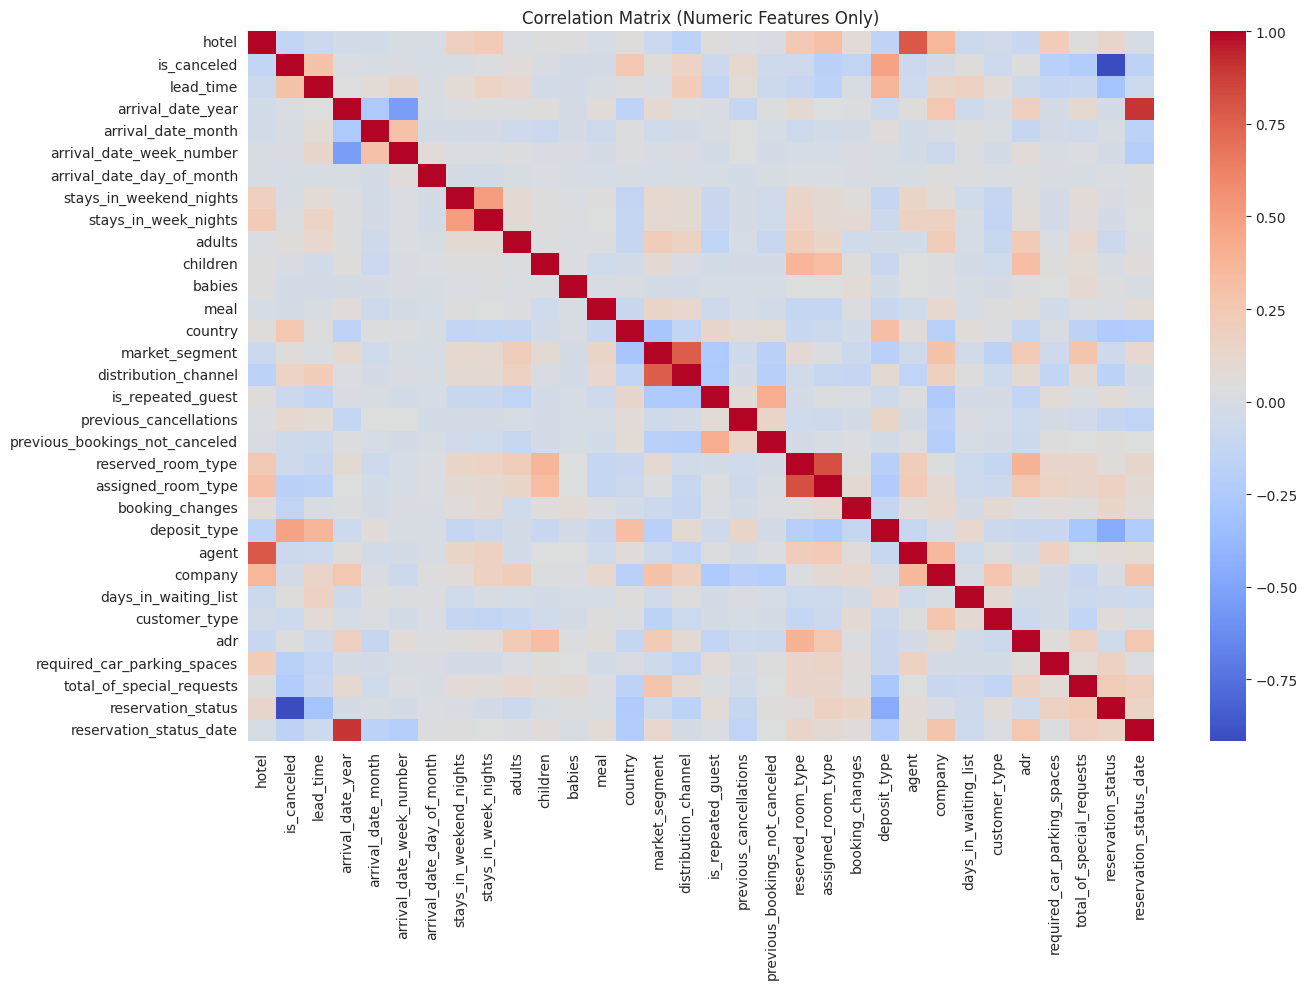

In [116]:
# Visualización de correlaciones
numeric_df = df.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(14, 10))
sns.heatmap(numeric_df.corr(), cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (Numeric Features Only)")
plt.tight_layout()
plt.show()

# Tasa de cancelacion

In [117]:
# Entrenamiento de modelo
X = df.drop("is_canceled", axis=1)
y = df["is_canceled"]

X = pd.get_dummies(X, drop_first=True)

assert X.select_dtypes(include='object').empty, "X contains non-numeric data types!"
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 1.0
[[14907     0]
 [    0  8971]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14907
           1       1.00      1.00      1.00      8971

    accuracy                           1.00     23878
   macro avg       1.00      1.00      1.00     23878
weighted avg       1.00      1.00      1.00     23878



## Tasa de cancelacion por mes

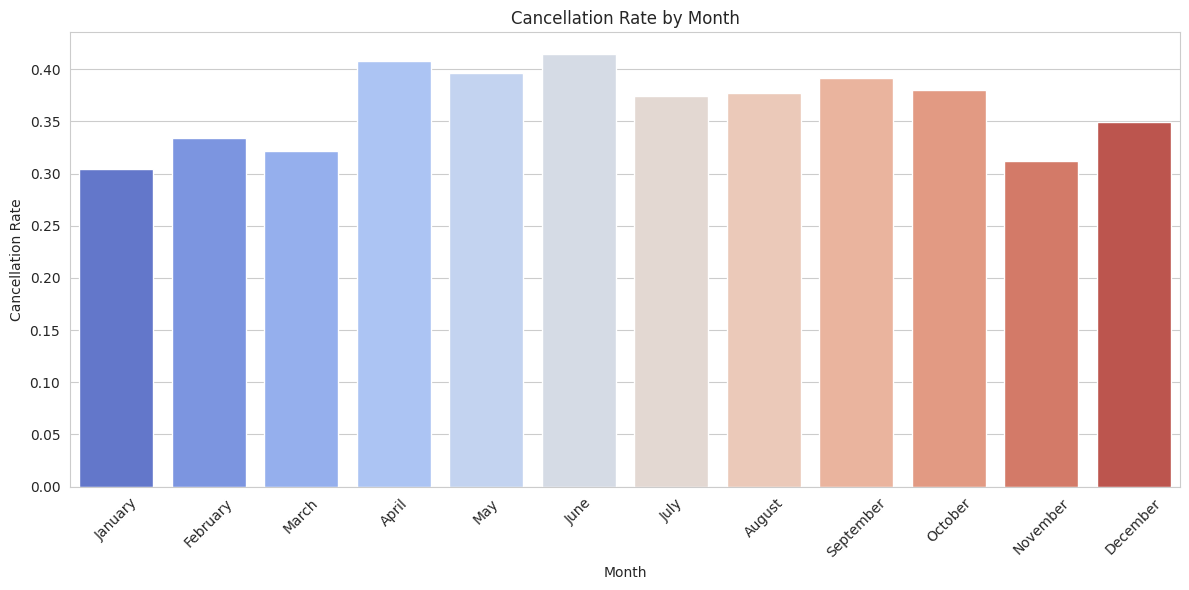

In [125]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June','July', 'August', 'September', 'October', 'November', 'December']
df['arrival_date_month'] = pd.Categorical(df['arrival_date_month'], categories=month_order, ordered=True)

cancel_rate_by_month = df.groupby('arrival_date_month', observed=True)['is_canceled'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x='arrival_date_month', y='is_canceled', data=cancel_rate_by_month, palette='coolwarm')
plt.title('Cancellation Rate by Month')
plt.ylabel('Cancellation Rate')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Tasa de cancelacion por tiempo promedio de estancia

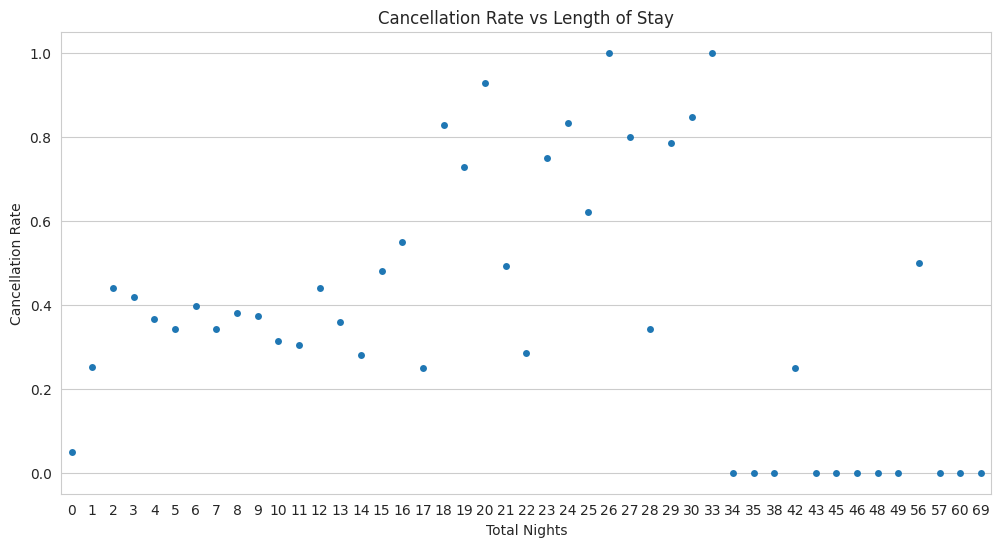

In [149]:
df['total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
stay_cancel_rate = df.groupby('total_nights')['is_canceled'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.stripplot(data=stay_cancel_rate, x='total_nights', y='is_canceled')
plt.title("Cancellation Rate vs Length of Stay")
plt.xlabel("Total Nights")
plt.ylabel("Cancellation Rate")
plt.show()

## Predicción de cancelacion de los futuros 12 meses

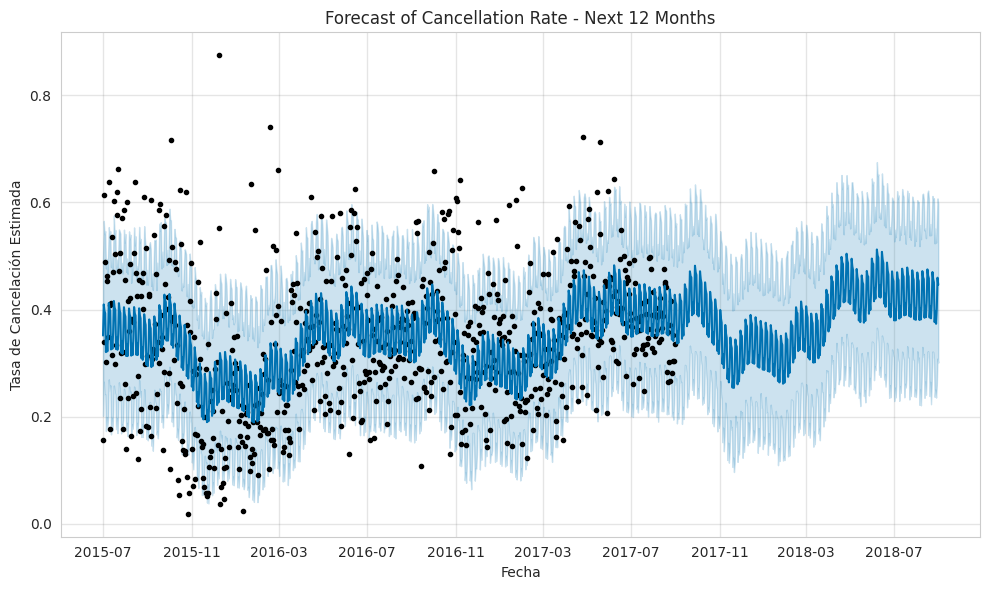

In [150]:
df['arrival_date_month'] = df['arrival_date_month'].astype(str).str.strip().str.title()
df['arrival_date'] = pd.to_datetime(
    df['arrival_date_year'].astype(str) + '-' +
    df['arrival_date_month'] + '-' +
    df['arrival_date_day_of_month'].astype(str),
    errors='coerce'
)

cancel_ts = df.groupby('arrival_date')['is_canceled'].mean().reset_index()
cancel_ts.columns = ['ds', 'y']

m = Prophet()
m.fit(cancel_ts)

future = m.make_future_dataframe(periods=365)  # 12 meses a futuro
forecast = m.predict(future)

fig = m.plot(forecast)
plt.title("Forecast of Cancellation Rate - Next 12 Months")
plt.xlabel("Fecha")
plt.ylabel("Tasa de Cancelación Estimada")
plt.tight_layout()
plt.show()


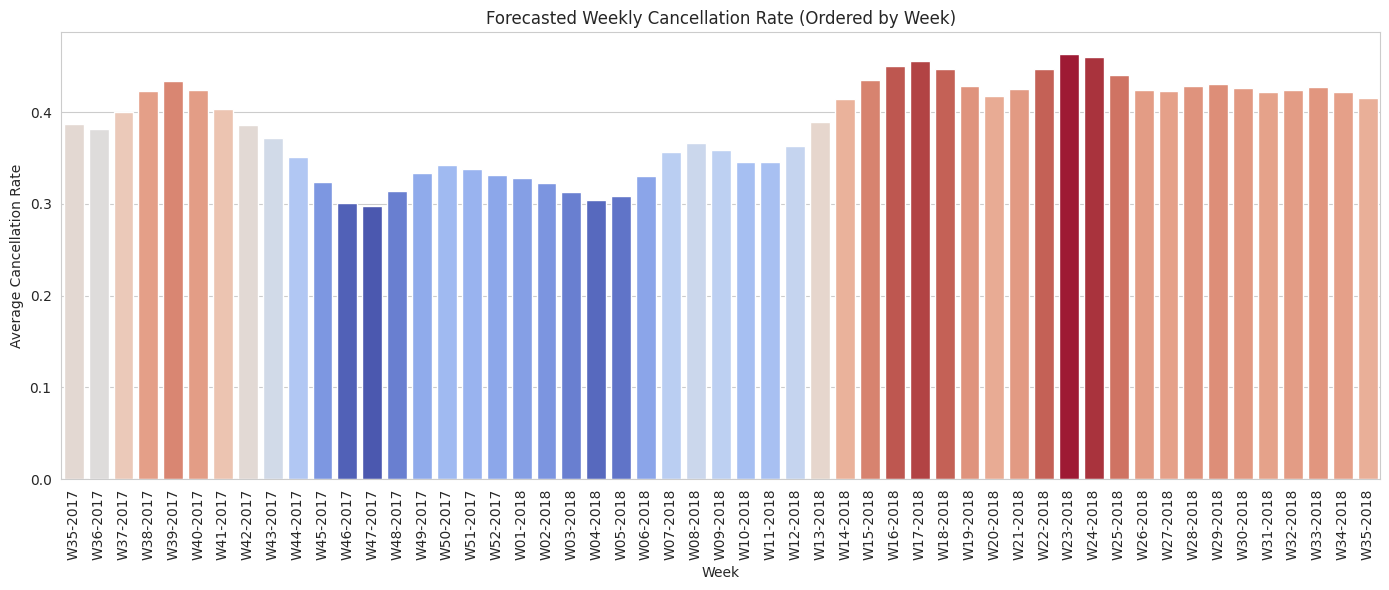

In [151]:
# Obtener semana, año y la fecha de inicio de semana (para ordenar)
forecast_next_12_months['year'] = forecast_next_12_months['ds'].dt.isocalendar().year
forecast_next_12_months['week'] = forecast_next_12_months['ds'].dt.isocalendar().week
forecast_next_12_months['week_start'] = forecast_next_12_months['ds'] - pd.to_timedelta(forecast_next_12_months['ds'].dt.weekday, unit='d')

# Crear etiqueta de año + semana
forecast_next_12_months['year_week'] = (
    'W' + forecast_next_12_months['week'].astype(str).str.zfill(2) + '-' + forecast_next_12_months['year'].astype(str)
)

# Agrupar por inicio de semana (para mantener orden cronológico)
weekly_forecast = forecast_next_12_months.groupby(['week_start', 'year_week'])['yhat'].mean().reset_index()

# Ordenar por fecha
weekly_forecast = weekly_forecast.sort_values('week_start')

# Normalizar colores
norm = plt.Normalize(weekly_forecast['yhat'].min(), weekly_forecast['yhat'].max())
colors = plt.cm.coolwarm(norm(weekly_forecast['yhat']))

# Graficar
plt.figure(figsize=(14,6))
sns.barplot(data=weekly_forecast, x='year_week', y='yhat', palette=colors)
plt.title("Forecasted Weekly Cancellation Rate (Ordered by Week)")
plt.xlabel("Week")
plt.ylabel("Average Cancellation Rate")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## Insights

In [162]:
def cancellation_insights(forecast_df):
    # Día con mayor y menor tasa
    max_day = forecast_df.loc[forecast_df['yhat'].idxmax()]
    min_day = forecast_df.loc[forecast_df['yhat'].idxmin()]

    # Estacionalidad semanal
    forecast_df['day_name'] = forecast_df['ds'].dt.day_name()
    dow_avg = forecast_df.groupby('day_name')['yhat'].mean()
    best_day = dow_avg.idxmin()
    worst_day = dow_avg.idxmax()

    # Estacionalidad mensual
    forecast_df['month'] = forecast_df['ds'].dt.month_name()
    month_avg = forecast_df.groupby('month')['yhat'].mean()
    best_month = month_avg.idxmin()
    worst_month = month_avg.idxmax()

    # Cambio fuerte semanal
    forecast_df['week_start'] = forecast_df['ds'] - pd.to_timedelta(forecast_df['ds'].dt.weekday, unit='d')
    weekly_avg = forecast_df.groupby('week_start')['yhat'].mean()
    max_change_week = weekly_avg.diff().idxmax()
    max_change_value = weekly_avg.diff().max()

    resumen_html = f"""
    <h3>🔍 Forecast Insights Summary (Sep 2017 – Aug 2018)</h3>

    <ul>
        <li><b>📅 Day with the highest estimated cancellation rate:</b> {max_day['ds'].date()} (Week {max_day['ds'].isocalendar().week}-{max_day['ds'].year}) – <b>{max_day['yhat']:.2f}</b></li>
        <li><b>📅 Day with the lowest estimated cancellation rate:</b> {min_day['ds'].date()} (Week {min_day['ds'].isocalendar().week}-{min_day['ds'].year}) – <b>{min_day['yhat']:.2f}</b></li>
    </ul>

    <b>📈 Weekly Seasonality:</b>
    <ul>
        <li>Day with the <b>highest average cancellations</b>: {worst_day}</li>
        <li>Day with the <b>lowest average cancellations</b>: {best_day}</li>
    </ul>

    <b>🗓️ Monthly Seasonality:</b>
    <ul>
        <li>Month with the <b>highest cancellations</b>: {worst_month}</li>
        <li>Month with the <b>lowest cancellations</b>: {best_month}</li>
    </ul>

    <b>⚠️ Largest Weekly Change:</b> occurred in the week starting <b>{max_change_week.date()}</b>, with an increase of <b>{max_change_value:.2f}</b> points.

    <p><b>💡 Recommendation:</b> Pay special attention to <b>{worst_day}s</b> and during the month of <b>{worst_month}</b>, as they concentrate the highest expected cancellation rates.</p>
    """

    display(HTML(resumen_html))

cancellation_insights(forecast_next_12_months)


# Temporadas altas y bajas

## Temporadas altas y bajas por semanas

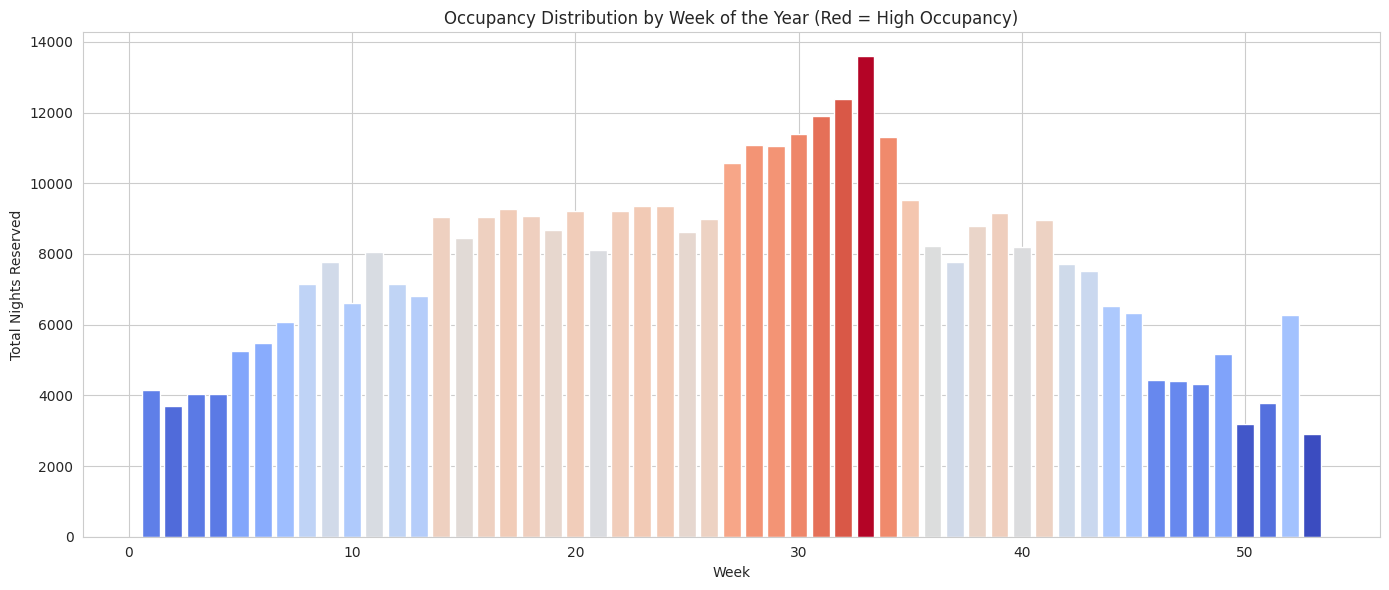

In [130]:
df['arrival_date_month'] = df['arrival_date_month'].astype(str).str.strip().str.title()
df['arrival_date'] = pd.to_datetime(
    df['arrival_date_year'].astype(str) + '-' +
    df['arrival_date_month'] + '-' +
    df['arrival_date_day_of_month'].astype(str),
    errors='coerce'
)

df['total_noches'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']

df['semana_iso'] = df['arrival_date'].dt.isocalendar().week
df['año'] = df['arrival_date'].dt.year

ocupacion_por_semana = df.groupby(df['arrival_date'].dt.isocalendar().week)['total_noches'].sum().reset_index()
ocupacion_por_semana.columns = ['semana_iso', 'total_noches']

norm = plt.Normalize(ocupacion_por_semana['total_noches'].min(), ocupacion_por_semana['total_noches'].max())
colors = plt.cm.coolwarm(norm(ocupacion_por_semana['total_noches']))  # más rojo = más ocupación

plt.figure(figsize=(14, 6))
plt.bar(ocupacion_por_semana['semana_iso'], ocupacion_por_semana['total_noches'], color=colors)
plt.title('Occupancy Distribution by Week of the Year (Red = High Occupancy)')
plt.xlabel('Week')
plt.ylabel('Total Nights Reserved')
plt.tight_layout()
plt.show()


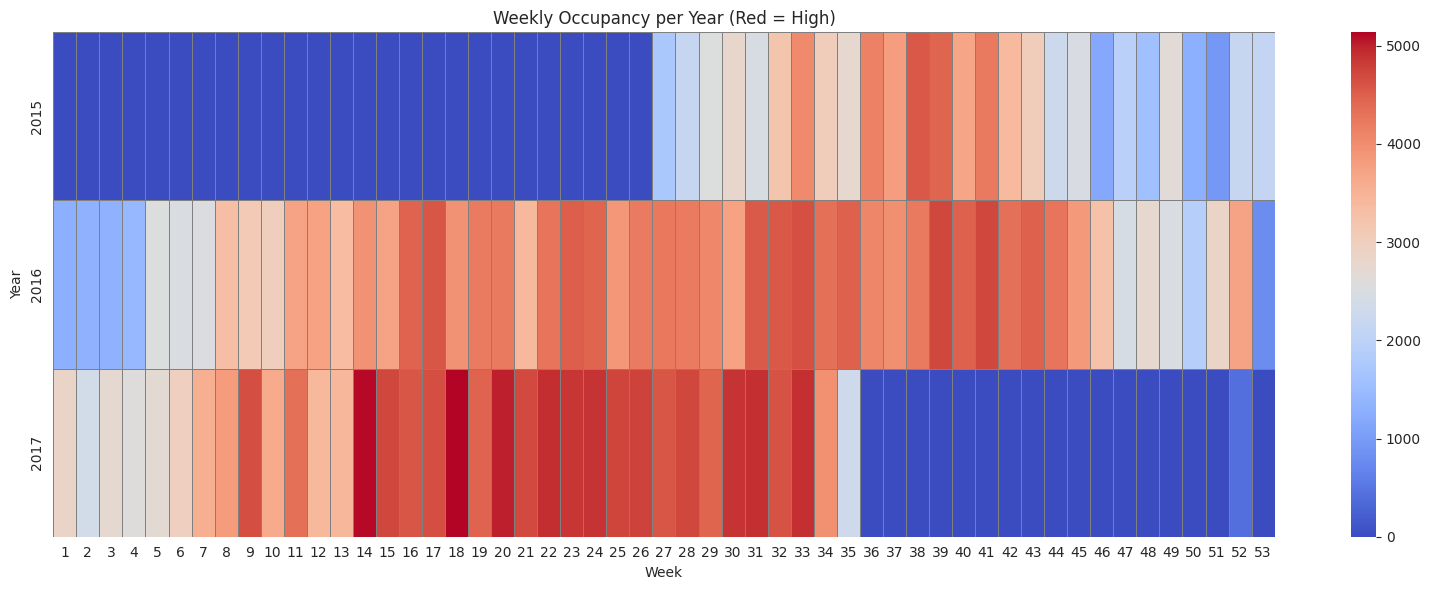

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

ocupacion_pivot = df.groupby([
    df['arrival_date'].dt.year,
    df['arrival_date'].dt.isocalendar().week
])['total_noches'].sum().unstack(fill_value=0)

plt.figure(figsize=(16, 6))
sns.heatmap(ocupacion_pivot, cmap='coolwarm', linewidths=0.5, linecolor='gray')
plt.title('Weekly Occupancy per Year (Red = High)')
plt.xlabel('Week')
plt.ylabel('Year')
plt.tight_layout()
plt.show()


## Predicciones de temporadas altas y bajas

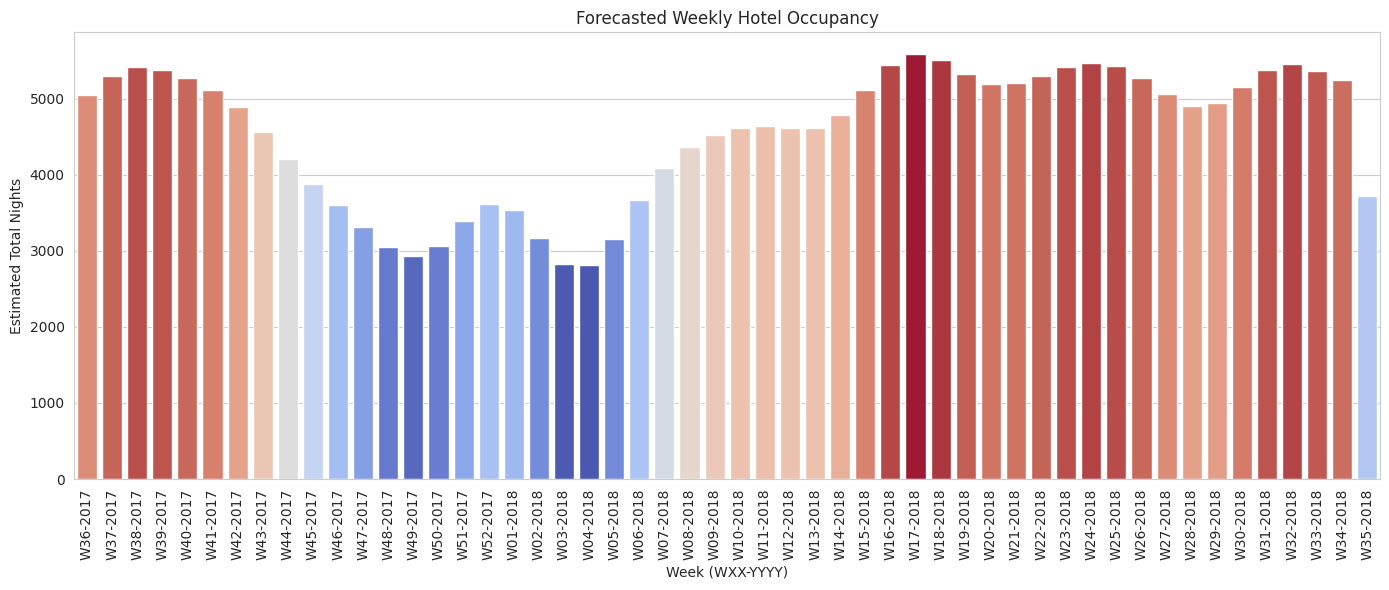

In [190]:
# Preprocesamiento base
df['total_nights'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']
daily_occupancy = df.groupby('arrival_date')['total_nights'].sum().reset_index()
daily_occupancy.columns = ['ds', 'y']

# Entrenar modelo Prophet
model = Prophet()
model.fit(daily_occupancy)

future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

# Calcular info de semana para cada fecha
forecast['year'] = forecast['ds'].dt.isocalendar().year
forecast['week'] = forecast['ds'].dt.isocalendar().week
forecast['week_start'] = forecast['ds'] - pd.to_timedelta(forecast['ds'].dt.weekday, unit='d')
forecast['year_week'] = 'W' + forecast['week'].astype(str).str.zfill(2) + '-' + forecast['year'].astype(str)

last_date = daily_occupancy['ds'].max()
forecast_future = forecast[forecast['ds'] > last_date].copy()
weekly_forecast = forecast_future.groupby(['week_start', 'year_week'])['yhat'].sum().reset_index()

q1 = weekly_forecast['yhat'].quantile(0.25)
q3 = weekly_forecast['yhat'].quantile(0.75)

def classify_season(y):
    if y >= q3:
        return 'High'
    elif y <= q1:
        return 'Low'
    else:
        return 'Mid'

weekly_forecast['season'] = weekly_forecast['yhat'].apply(classify_season)
weekly_forecast = weekly_forecast[weekly_forecast['week_start'] >= pd.to_datetime("2017-09-04")]


# Conteo de semanas por temporada
conteo_temporadas = weekly_forecast['season'].value_counts().to_dict()

weekly_forecast = weekly_forecast.sort_values('week_start')

norm = plt.Normalize(weekly_forecast['yhat'].min(), weekly_forecast['yhat'].max())
colors = plt.cm.coolwarm(norm(weekly_forecast['yhat']))

plt.figure(figsize=(14,6))
sns.barplot(data=weekly_forecast, x='year_week', y='yhat', palette=colors)
plt.title("Forecasted Weekly Hotel Occupancy")
plt.xlabel("Week (WXX-YYYY)")
plt.ylabel("Estimated Total Nights")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## Insights

In [195]:
def occupancy_insights(weekly_forecast):
    weekly_forecast['year'] = pd.to_datetime(weekly_forecast['week_start']).dt.isocalendar().year
    weekly_forecast['week'] = pd.to_datetime(weekly_forecast['week_start']).dt.isocalendar().week

    # Semana con mayor y menor ocupación
    max_week = weekly_forecast.loc[weekly_forecast['yhat'].idxmax()]
    min_week = weekly_forecast.loc[weekly_forecast['yhat'].idxmin()]

    # Conteo de semanas por tipo de temporada
    conteo_temporadas = weekly_forecast['season'].value_counts().to_dict()

    # Fechas de inicio de temporada
    def week_to_date(year, week):
        return pd.to_datetime(f'{year}-W{int(week)}-1', format='%G-W%V-%u')

    high_weeks = weekly_forecast[weekly_forecast['season'] == 'High']
    low_weeks = weekly_forecast[weekly_forecast['season'] == 'Low']

    high_start = week_to_date(high_weeks.iloc[0]['year'], high_weeks.iloc[0]['week']) if not high_weeks.empty else "N/A"
    low_start = week_to_date(low_weeks.iloc[0]['year'], low_weeks.iloc[0]['week']) if not low_weeks.empty else "N/A"

    resumen_html = f"""
    <h3>📊 Hotel Occupancy Forecast – Season Insights</h3>

    <ul>
        <li><b>📈 Week with highest forecasted demand:</b> Week {max_week['week']} of {max_week['year']} – <b>{max_week['yhat']:.0f} nights</b></li>
        <li><b>📉 Week with lowest forecasted demand:</b> Week {min_week['week']} of {min_week['year']} – <b>{min_week['yhat']:.0f} nights</b></li>
    </ul>

    <b>📅 Season Distribution:</b>
    <ul>
        <li><b>High season weeks:</b> {conteo_temporadas.get('High', 0)}</li>
        <li><b>Mid season weeks:</b> {conteo_temporadas.get('Mid', 0)}</li>
        <li><b>Low season weeks:</b> {conteo_temporadas.get('Low', 0)}</li>
    </ul>

    <b>🗓️ Approximate season start dates:</b>
    <ul>
        <li><b>First High Season week:</b> {high_start.strftime('%B %d, %Y') if high_start else 'N/A'}</li>
        <li><b>First Low Season week:</b> {low_start.strftime('%B %d, %Y') if low_start else 'N/A'}</li>
    </ul>

    <p><b>💡 Recommendation:</b> Focus marketing, staffing, and pricing strategies during high season weeks
    <b>{high_weeks['week'].min()}–{high_weeks['week'].max()}</b>, and consider promotions or maintenance during low season weeks.
    """

    display(HTML(resumen_html))

occupancy_insights(weekly_forecast)


# Estancia promedio

## Estancia promedio por mes

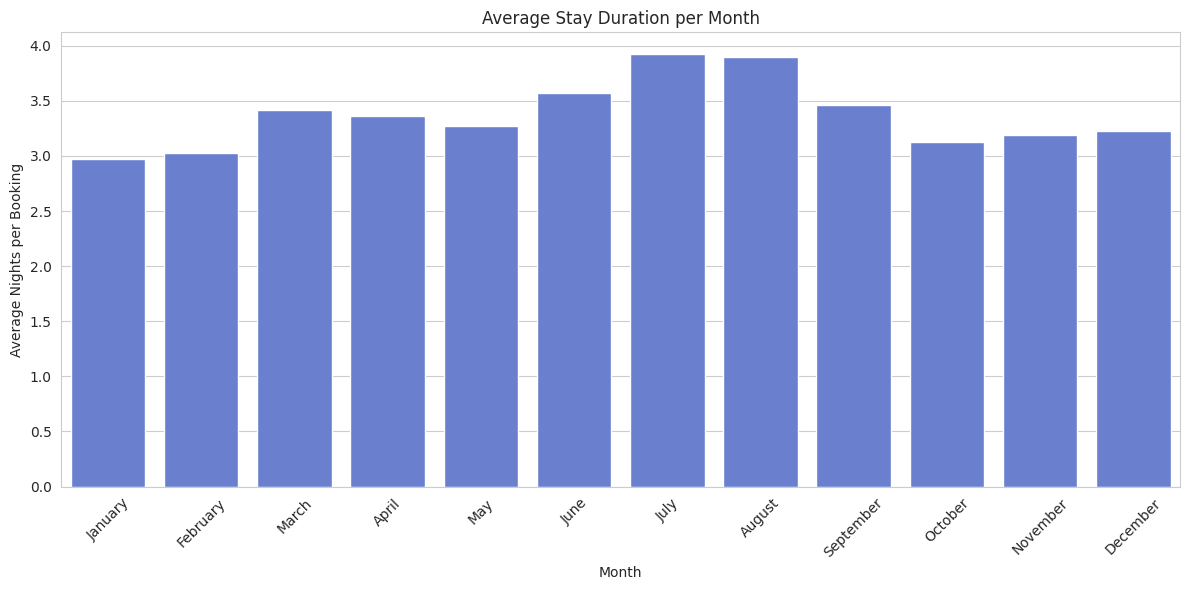

In [133]:
df['total_nights'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']

df['month'] = df['arrival_date'].dt.month_name()

month_order = ['January', 'February', 'March', 'April', 'May', 'June','July', 'August', 'September', 'October', 'November', 'December']
df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)

duracion_por_mes = df.groupby('month')['total_nights'].mean().reset_index()
duracion_por_mes.columns = ['Month', 'Average Stay (Nights)']

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.barplot(data=duracion_por_mes, x='Month', y='Average Stay (Nights)', color = '#5976e0')
plt.title('Average Stay Duration per Month')
plt.xlabel('Month')
plt.ylabel('Average Nights per Booking')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


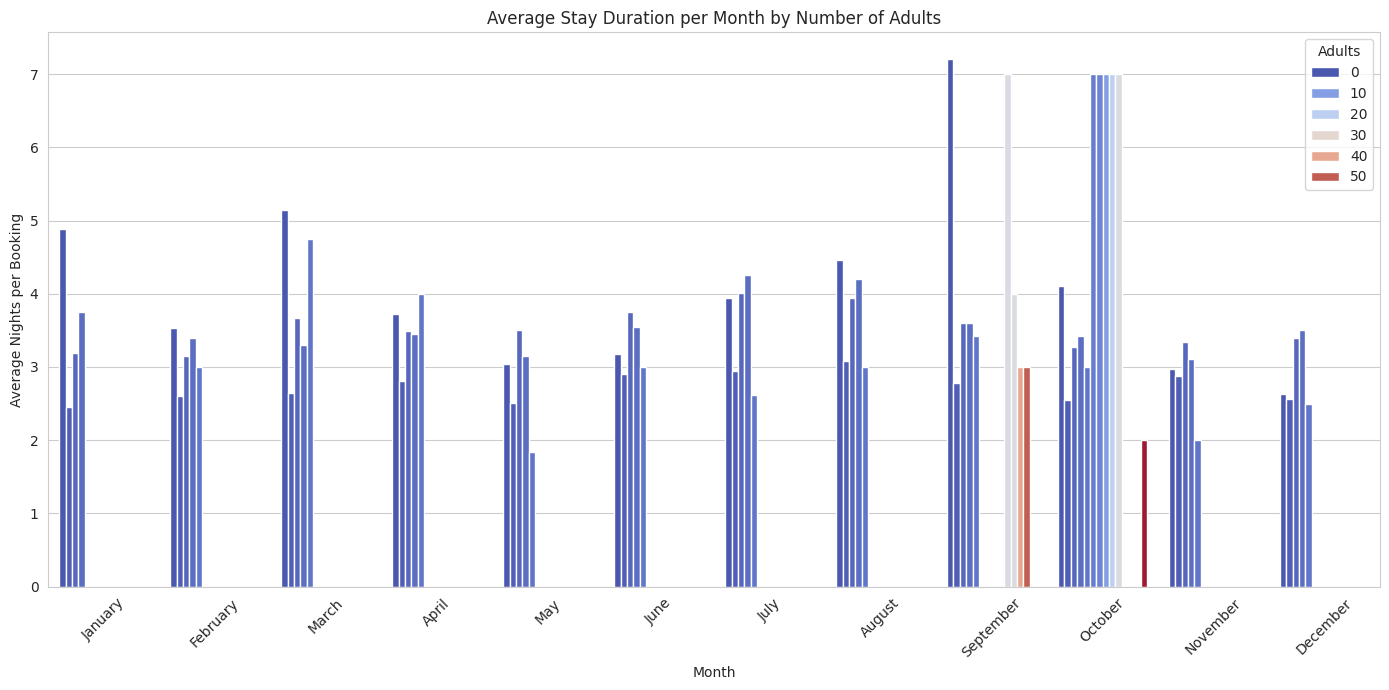

In [134]:
df['total_nights'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']

df['month'] = df['arrival_date'].dt.month_name()
month_order = ['January', 'February', 'March', 'April', 'May', 'June','July', 'August', 'September', 'October', 'November', 'December']
df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)

duracion_por_adultos_mes = df.groupby(['adults', 'month'])['total_nights'].mean().reset_index()
duracion_por_adultos_mes.columns = ['Adults', 'Month', 'Average Stay (Nights)']

plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")
sns.barplot(data=duracion_por_adultos_mes, x='Month', y='Average Stay (Nights)', hue='Adults', palette='coolwarm')
plt.title('Average Stay Duration per Month by Number of Adults')
plt.xlabel('Month')
plt.ylabel('Average Nights per Booking')
plt.xticks(rotation=45)
plt.legend(title='Adults')
plt.tight_layout()
plt.show()


## Predicciones de estancia promedio

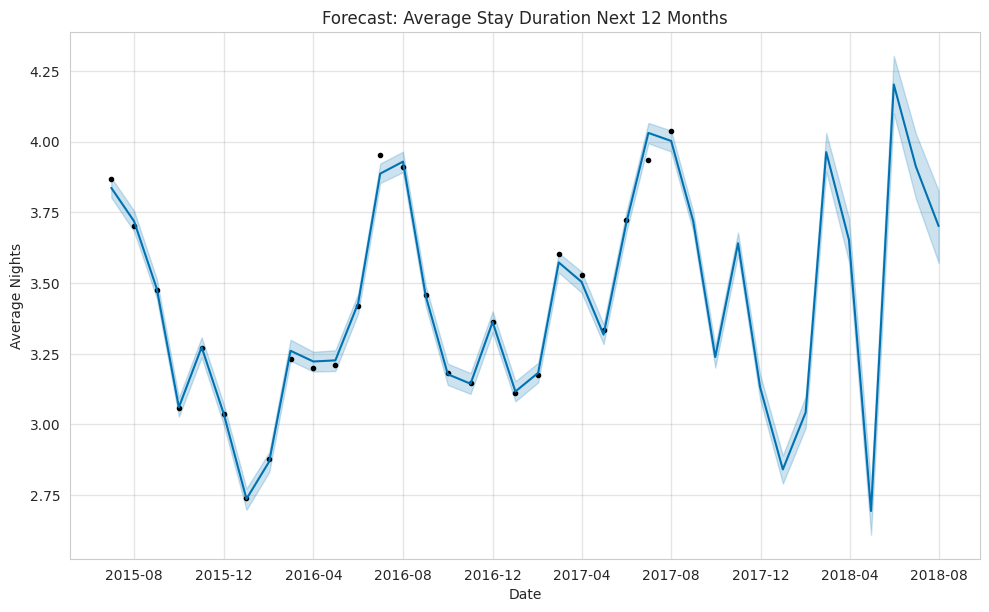

In [214]:
df['total_nights'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']
df['month_start'] = df['arrival_date'].dt.to_period('M').dt.to_timestamp()

promedio_mensual = df.groupby('month_start')['total_nights'].mean().reset_index()
promedio_mensual.columns = ['ds', 'y']  # Prophet necesita ds para fecha, y para valor

model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(promedio_mensual)

future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

model.plot(forecast)
plt.title('Forecast: Average Stay Duration Next 12 Months')
plt.xlabel('Date')
plt.ylabel('Average Nights')
plt.show()

In [215]:
# Tabla de los proximos 12 meses
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
26,2017-08-31,3.718761,3.682364,3.751935
27,2017-09-30,3.238226,3.201006,3.276989
28,2017-10-31,3.640690,3.601634,3.678755
29,2017-11-30,3.132024,3.089409,3.177017
30,2017-12-31,2.840984,2.790942,2.890662
31,2018-01-31,3.042434,2.987352,3.098873
32,2018-02-28,3.962590,3.894296,4.030409
33,2018-03-31,3.652160,3.574917,3.729391
34,2018-04-30,2.694104,2.610096,2.781161
35,2018-05-31,4.201827,4.099629,4.302589


## Insights

In [216]:
def stay_duration_insights(forecast_df):
    import pandas as pd
    from IPython.display import display, HTML

    # Tomar los últimos 12 meses del forecast (las predicciones)
    forecast_future = forecast_df[['ds', 'yhat']].tail(12).copy()
    forecast_future['ds'] = pd.to_datetime(forecast_future['ds'])
    forecast_future['year'] = forecast_future['ds'].dt.year
    forecast_future['month'] = forecast_future['ds'].dt.strftime('%B')

    # Calcular promedio y desviación estándar
    avg_stay = forecast_future['yhat'].mean()
    std_dev = forecast_future['yhat'].std()

    # Clasificar según desviación estándar
    def classify_season(y):
        if y > avg_stay + std_dev:
            return 'High'
        elif y < avg_stay - std_dev:
            return 'Low'
        else:
            return 'Mid'

    forecast_future['season'] = forecast_future['yhat'].apply(classify_season)

    # Resumen de conteo por temporada
    season_counts = forecast_future['season'].value_counts()

    # Obtener mes con mayor y menor estancia
    max_row = forecast_future.loc[forecast_future['yhat'].idxmax()]
    min_row = forecast_future.loc[forecast_future['yhat'].idxmin()]

    # Filtrar nombres de meses por tipo
    high_months = forecast_future[forecast_future['season'] == 'High']['month'] + ' ' + forecast_future[forecast_future['season'] == 'High']['year'].astype(str)
    mid_months = forecast_future[forecast_future['season'] == 'Mid']['month']
    low_months = forecast_future[forecast_future['season'] == 'Low']['month'] + ' ' + forecast_future[forecast_future['season'] == 'Low']['year'].astype(str)

    # Crear HTML
    resumen_html = f"""
    <h3>📅 Monthly Stay Duration Forecast</h3>

    <ul>
        <li><b>📈 Month with highest average stay:</b> {max_row['month']} {max_row['year']} – <b>{max_row['yhat']:.2f} nights</b></li>
        <li><b>📉 Month with lowest average stay:</b> {min_row['month']} {min_row['year']} – <b>{min_row['yhat']:.2f} nights</b></li>
    </ul>

    <b>🔍 Seasonal Categorization (based on ±1 std deviation):</b>
    <ul>
        <li><b>High season months:</b> {season_counts.get('High', 0)} ({', '.join(high_months)})</li>
        <li><b>Mid season months:</b> {season_counts.get('Mid', 0)}</li>
        <li><b>Low season months:</b> {season_counts.get('Low', 0)} ({', '.join(low_months)})</li>
    </ul>

    <p><b>💡 Recommendations:</b></p>
    <ul>
        <li>📢 <b>High season:</b> focus on promotions or pricing strategies during months like <b>{', '.join(high_months)}</b>.</li>
        <li>📉 <b>Low season:</b> consider discounts, events or renovations in <b>{', '.join(low_months)}</b>.</li>
        <li>🧭 <b>Mid season:</b> monitor behavior and trends for adaptive planning.</li>
    </ul>
    """

    display(HTML(resumen_html))


stay_duration_insights(forecast)